# Pipeline + Training

In [1]:
# %load_ext autoreload
# %autoreload 2

# import sys

# sys.path.append('../../../../')

# from importlib import reload

In [2]:
import matplotlib.pyplot as plt
import matplotlib.tri as mtri
import numpy as np
from typing import Tuple, List

In [48]:
import torch
import pandas as pd
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam

from coma.models import init_coma
from coma.datasets.ukbb_meshdata import (
    UKBBMeshDataset, VerticesDataLoader, get_data_from_polydata
)
from coma.utils import transforms
from coma.utils.train_eval_svi import run_svi


preprocessor = transforms.get_transforms()

mesh_path = '/vol/biomedic3/bglocker/brainshapes'
cache_path = '/vol/bitbucket/rrr2417/deepscm/deepscm/experiments/medical_meshes/notebooks'
split = 0.8
substructures = ['BrStem']
feature_name_map = {
    '31-0.0': 'Sex',
    '21003-0.0': 'Age',
    '25025-2.0': 'Brain Stem Volume',
}

csv_path = '/vol/biomedic3/bglocker/brainshapes/ukb21079_extracted.csv'
metadata_df = pd.read_csv(csv_path)

total_train_dataset = UKBBMeshDataset(
    mesh_path,
    substructures=substructures,
    split=split,
    train=True,
    transform=preprocessor,
    reload_path=False,
    features_df=metadata_df,
    feature_name_map=feature_name_map,
    cache_path = cache_path,
)
test_dataset = UKBBMeshDataset(
    mesh_path,
    substructures=substructures,
    split=split,
    train=False,
    transform=preprocessor,
    reload_path=False,
    features_df=metadata_df,
    feature_name_map=feature_name_map,
    cache_path = cache_path,
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

val_split = 0.1
total_train_length = len(total_train_dataset)
val_length = int(val_split * total_train_length)
train_length = total_train_length - val_length

train_dataset, val_dataset = torch.utils.data.random_split(
    total_train_dataset,
    lengths=[train_length, val_length],
    generator=torch.Generator().manual_seed(42),
)

batch_size = 10
train_dataloader = VerticesDataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=False,
)
val_dataloader = VerticesDataLoader(
    val_dataset,
    batch_size=20,
    shuffle=False,
)
test_dataloader = VerticesDataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
)

train_plotting_point = train_dataset.dataset.get_raw(train_dataset.indices[0])
train_data = get_data_from_polydata(train_plotting_point)
template = train_data

/vol/bitbucket/rrr2417/deepscm/ENV2/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3155: DtypeWarning: Columns (255,273,274,275,279,351,451,452,453,454,1344,1347,1350,1351,1352,1396,1397,1398,1399,1400,1401,1402,1428,1429,1430,1431,1432,1433,1434,1492,1596,1597,1598,1599,1600,1601,1602,1603,1604,1605,1606,1607,1608,1609,1610,1611,1612,1613,1614,1615,1616,1968,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024,2025,2026,2027,2028,2029,2030,2031,2032,2033,2034,2035,2036,2037,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047,2048,2049,2050,2051,2052,2053,2054,2055,2056,2057,2058,2059,2060,2061,2062,2063,2064,2065,2066,2431) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [49]:
in_channels = 3
out_channels = [32, 32, 32, 64]
latent_channels = 20
K = 10
n_blocks = 1
pooling_factor = 4

model = init_coma(
    'vae_svi',
    template,
    device,
    pooling_factor,
    in_channels=in_channels,
    out_channels=out_channels,
    latent_channels=latent_channels,
    K=K, n_blocks=n_blocks,
)
model = model.double()
print()
print(model)
print()

total_params = sum(p.numel() for p in model.parameters())
print()
print(total_params)
print()

optimiser = Adam({'lr': 1e-3})
loss = Trace_ELBO(num_particles=1)
svi = SVI(model.model, model.guide, optimiser, loss=loss)


VAE(
  (encoder_unit): Encoder(
    (layers): ModuleList(
      (0): Enblock(
        (blocks): ModuleList(
          (0): ChebConv(3, 32, K=10, normalization=sym)
        )
      )
      (1): Enblock(
        (blocks): ModuleList(
          (0): ChebConv(32, 32, K=10, normalization=sym)
        )
      )
      (2): Enblock(
        (blocks): ModuleList(
          (0): ChebConv(32, 32, K=10, normalization=sym)
        )
      )
      (3): Enblock(
        (blocks): ModuleList(
          (0): ChebConv(32, 64, K=10, normalization=sym)
        )
      )
      (4): Linear(in_features=192, out_features=20, bias=True)
    )
  )
  (decoder_unit): Decoder(
    (layers): ModuleList(
      (0): Linear(in_features=20, out_features=192, bias=True)
      (1): Deblock(
        (blocks): ModuleList(
          (0): ChebConv(64, 64, K=10, normalization=sym)
        )
      )
      (2): Deblock(
        (blocks): ModuleList(
          (0): ChebConv(64, 32, K=10, normalization=sym)
        )
      )
   

In [50]:
trial_graph = torch.ones((5, 642, 3))
res = model.generate(trial_graph.to(device).double(), device)
res

tensor([[[-0.4711, -1.1697, -1.1248],
         [-1.0329, -0.3126, -0.8330],
         [ 0.2974, -0.7831, -0.1295],
         ...,
         [-0.0112, -0.1683, -1.0318],
         [-2.1979, -0.2049, -1.0965],
         [ 1.3452, -0.5986, -0.3347]],

        [[ 0.8526, -0.5757, -0.3626],
         [ 1.7789, -0.0492,  0.4480],
         [-1.2475,  1.2882, -0.1910],
         ...,
         [ 0.0115,  0.7319, -1.5113],
         [ 0.8845, -1.0675, -1.1383],
         [ 1.6753, -0.2478,  0.7064]],

        [[ 1.2686, -0.0100, -0.6974],
         [ 0.2952,  1.4098, -0.0164],
         [ 1.2604,  1.6520,  1.1337],
         ...,
         [-0.8159, -0.8420, -1.4689],
         [ 0.0610, -0.3464,  1.3965],
         [ 0.8942, -0.3051,  0.8681]],

        [[-0.6949,  0.4665, -0.5083],
         [-1.4130, -0.0066,  2.2412],
         [-0.2789, -1.5684, -1.2092],
         ...,
         [ 0.7129,  0.9581,  0.2184],
         [-0.3116, -1.8577,  0.2483],
         [ 0.0749,  1.5213, -1.7904]],

        [[ 0.2837, -0.38

In [51]:
# run_svi(svi, train_dataloader, val_dataloader, 10, device)

In [52]:
from coma.utils.train_eval_svi import train_eval_svi

In [53]:
for val_batch in val_dataloader:
    # print(val_batch.features)
    break

# Specifically picked EIDs for interesting brain shapes / volumes
plotting_eids = [5099462, 5843672, 6024555, 5178280, 5182959, 5548167, 5272090]
mask = val_batch.features.eid.isin(plotting_eids)
idxs = np.argwhere(np.array(mask)).flatten()
val_batch_df = val_batch.features[mask]
val_batch_df.head(len(plotting_eids))

,eid,Sex,Age,Brain Stem Volume
6651,5182959,0,61,22314
10743,6024555,1,63,20412
9508,5099462,0,64,17905
7419,5843672,1,55,26729
6384,5272090,0,52,24183
116,5178280,1,61,23390
7848,5548167,1,63,28637


In [54]:
def plot_wireframe_and_meshes(
    vertices: np.ndarray,
    pred_verts: np.ndarray,
    triangles: np.ndarray,
    figsize: Tuple[int, int] = (20, 15),
    elevations: List[int] = [0],
    azimuths: int = 5,
    alpha: float = 0.8,
    wireframe_alpha: float = 0.0,
):
    triang = mtri.Triangulation(vertices[:, 0], vertices[:, 1], triangles=triangles)
    z = vertices[:, 2].flatten()
    
    triang_pred = mtri.Triangulation(pred_verts[:, 0], pred_verts[:, 1], triangles=triangles)
    pred_z = pred_verts[:, 2].flatten()

    nrows = len(elevations)
    ncols = azimuths
    fig, ax = plt.subplots(
        nrows=nrows,
        ncols=ncols,
        figsize=figsize,
        subplot_kw=dict(projection="3d"),
    )
    ax = ax.reshape(-1, ncols)

    azimuth_intervals = 360 / ncols
    elevation_intervals = 360 / nrows

    for j, elevation in enumerate(elevations):
        for i in range(ncols):
            azimuth = azimuth_intervals * i
            ax[j][i].set_title(f'E: {int(elevation)}, A: {int(azimuth)}')
            ax[j][i].view_init(elevation, azimuth)
            ax[j][i].plot_trisurf(triang, z, edgecolor='grey', alpha=alpha)
            ax[j][i].plot_trisurf(triang_pred, pred_z, edgecolor='lightpink', alpha=wireframe_alpha)
            ax[j][i].set_xlabel('x')
            ax[j][i].set_ylabel('y')
            ax[j][i].set_zlabel('z')

    plt.show()

100%|██████████| 15/15 [00:06<00:00,  2.34it/s]


0 7608484.287128227 7582978.616594785
{'eid': 5843672, 'Sex': 1, 'Age': 55, 'Brain Stem Volume': 26729}


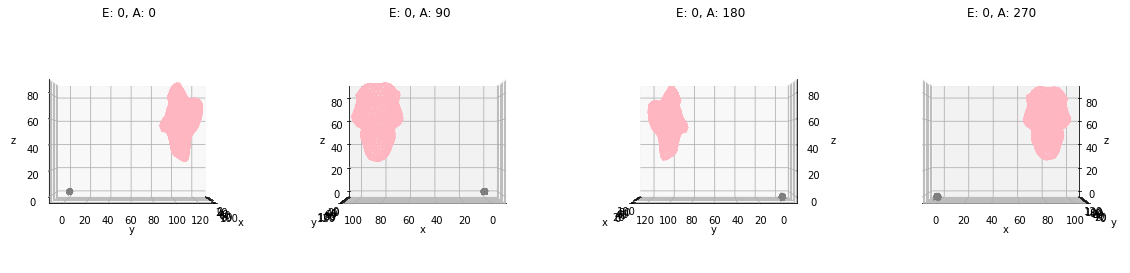

{'eid': 5272090, 'Sex': 0, 'Age': 52, 'Brain Stem Volume': 24183}


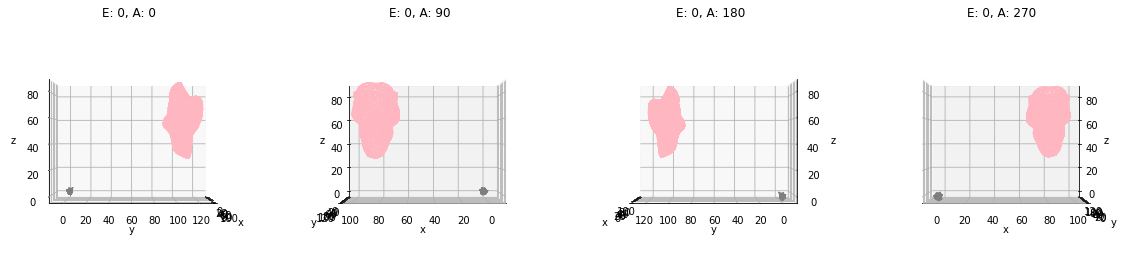

{'eid': 5178280, 'Sex': 1, 'Age': 61, 'Brain Stem Volume': 23390}


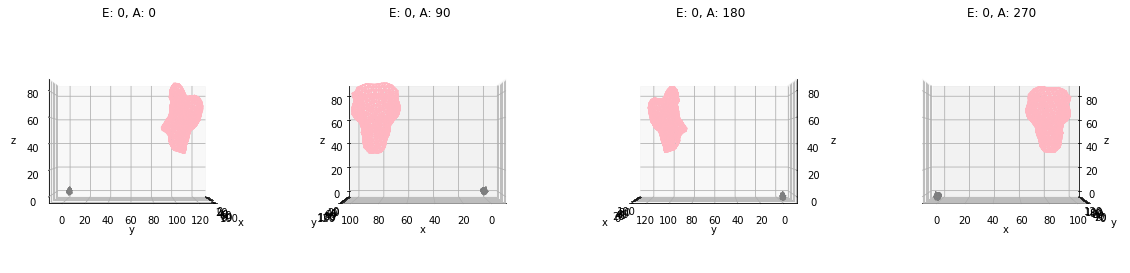

{'eid': 5548167, 'Sex': 1, 'Age': 63, 'Brain Stem Volume': 28637}


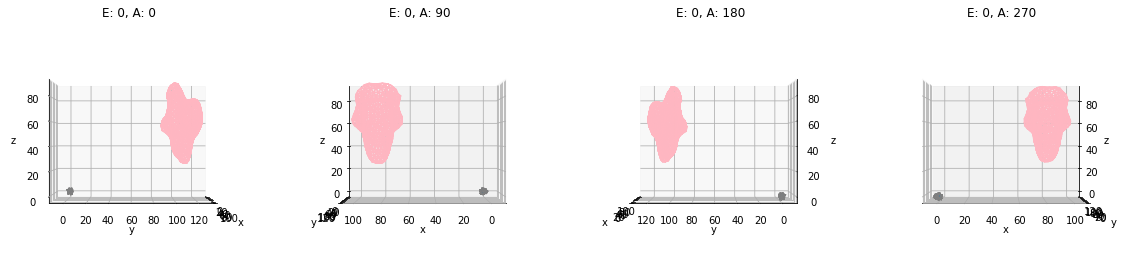

  0%|          | 0/262 [00:00<?, ?it/s]

-------------


100%|██████████| 15/15 [00:04<00:00,  3.00it/s]


1 7586583.62096077 7622052.006269346
{'eid': 5843672, 'Sex': 1, 'Age': 55, 'Brain Stem Volume': 26729}


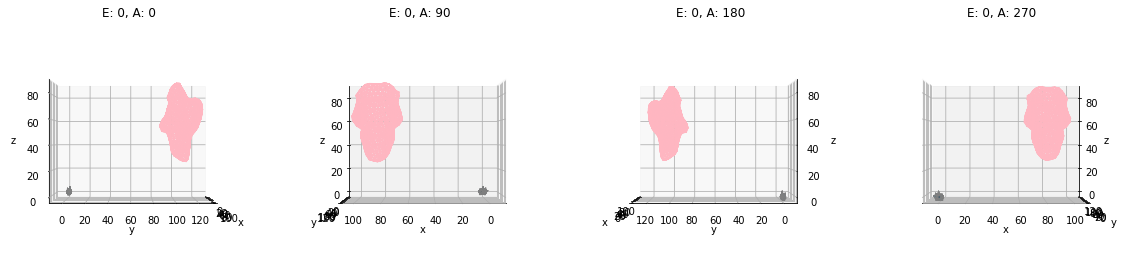

{'eid': 5272090, 'Sex': 0, 'Age': 52, 'Brain Stem Volume': 24183}


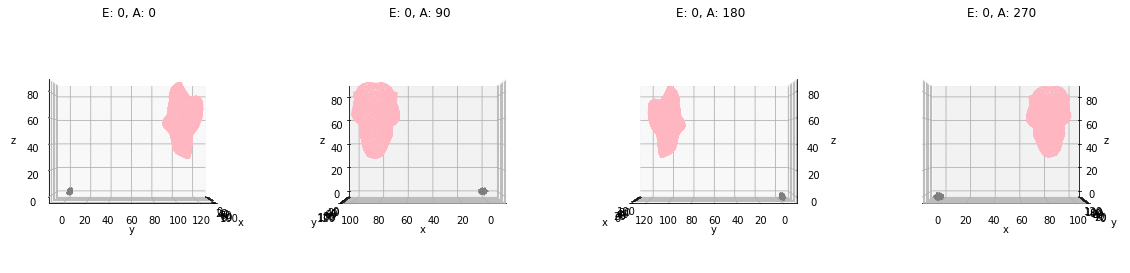

{'eid': 5178280, 'Sex': 1, 'Age': 61, 'Brain Stem Volume': 23390}


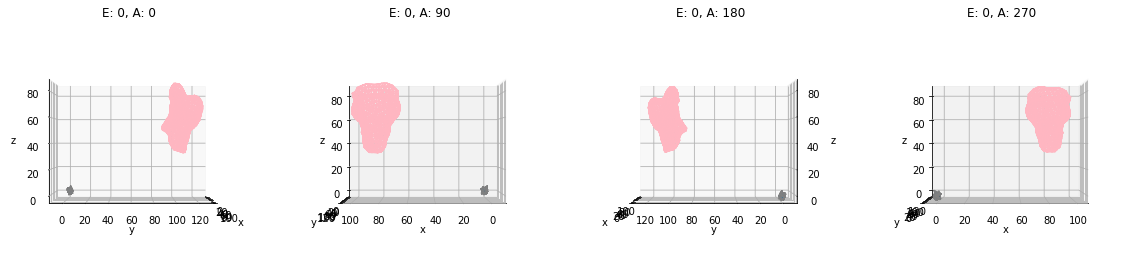

{'eid': 5548167, 'Sex': 1, 'Age': 63, 'Brain Stem Volume': 28637}


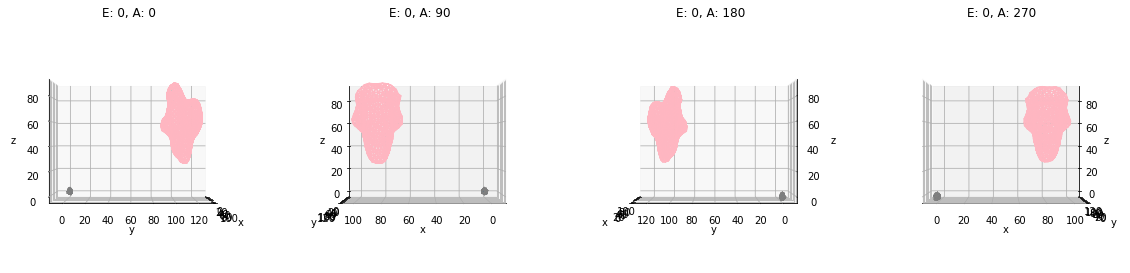

  0%|          | 0/262 [00:00<?, ?it/s]

-------------


100%|██████████| 15/15 [00:05<00:00,  2.82it/s]


2 7603788.706179519 7593359.107782916
{'eid': 5843672, 'Sex': 1, 'Age': 55, 'Brain Stem Volume': 26729}


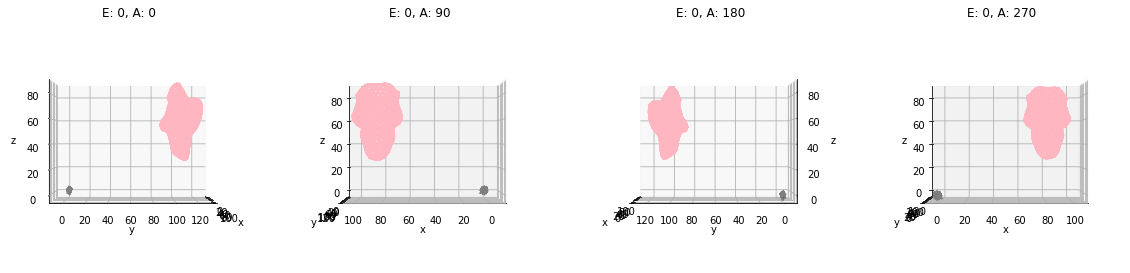

{'eid': 5272090, 'Sex': 0, 'Age': 52, 'Brain Stem Volume': 24183}


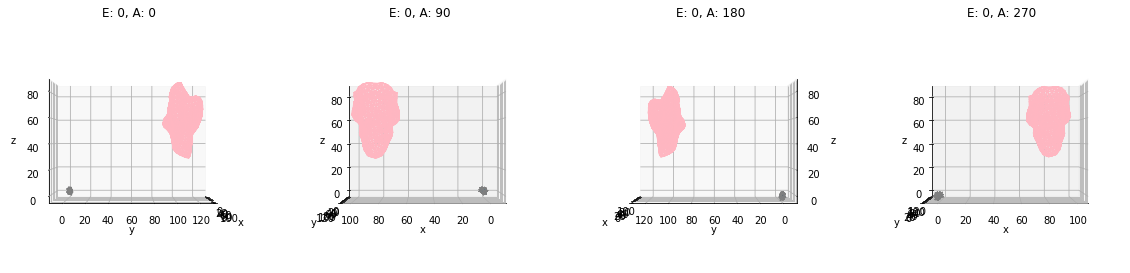

{'eid': 5178280, 'Sex': 1, 'Age': 61, 'Brain Stem Volume': 23390}


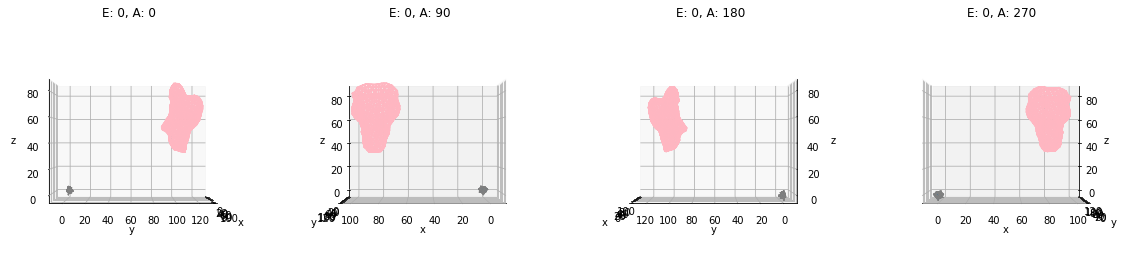

{'eid': 5548167, 'Sex': 1, 'Age': 63, 'Brain Stem Volume': 28637}


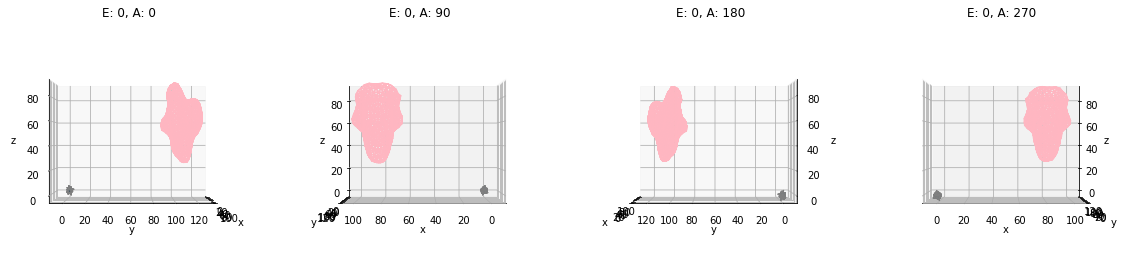

  0%|          | 0/262 [00:00<?, ?it/s]

-------------


100%|██████████| 15/15 [00:04<00:00,  3.02it/s]


3 7594620.5245506335 7576538.91328604
{'eid': 5843672, 'Sex': 1, 'Age': 55, 'Brain Stem Volume': 26729}


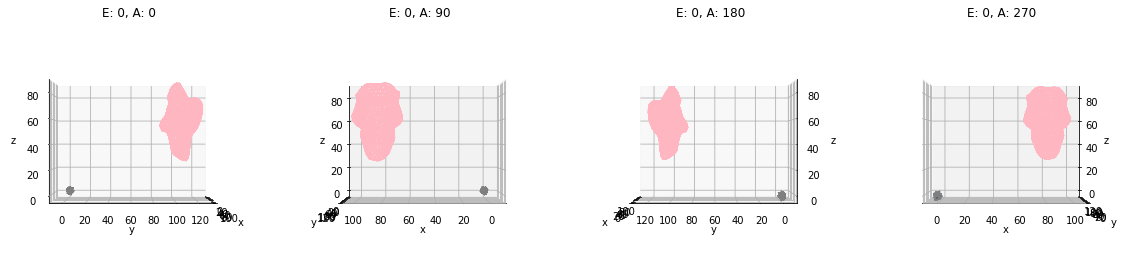

{'eid': 5272090, 'Sex': 0, 'Age': 52, 'Brain Stem Volume': 24183}


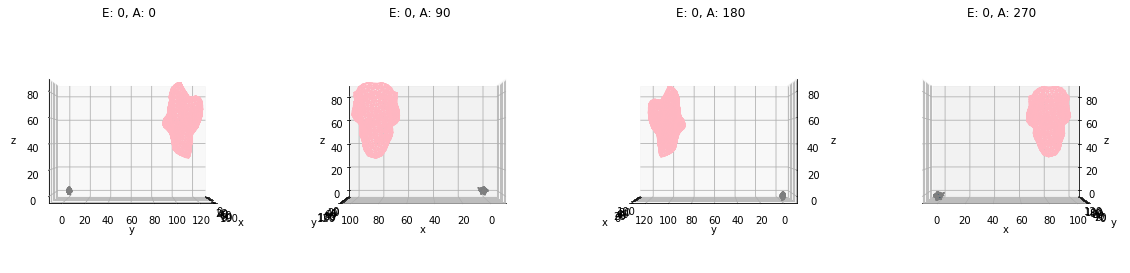

{'eid': 5178280, 'Sex': 1, 'Age': 61, 'Brain Stem Volume': 23390}


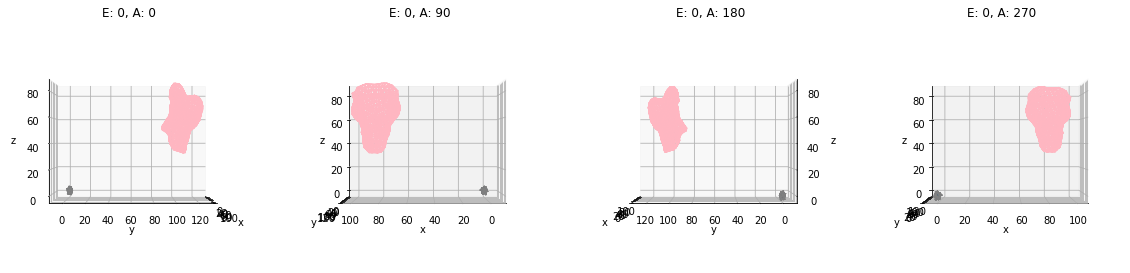

{'eid': 5548167, 'Sex': 1, 'Age': 63, 'Brain Stem Volume': 28637}


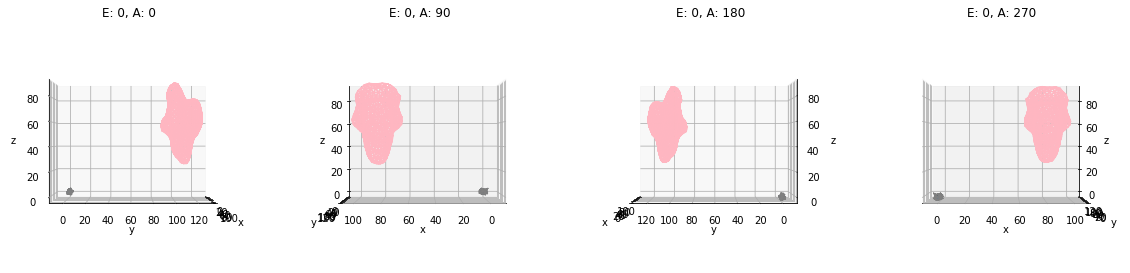

  0%|          | 0/262 [00:00<?, ?it/s]

-------------


100%|██████████| 15/15 [00:05<00:00,  2.64it/s]


4 7588499.041193295 7553464.419570184
{'eid': 5843672, 'Sex': 1, 'Age': 55, 'Brain Stem Volume': 26729}


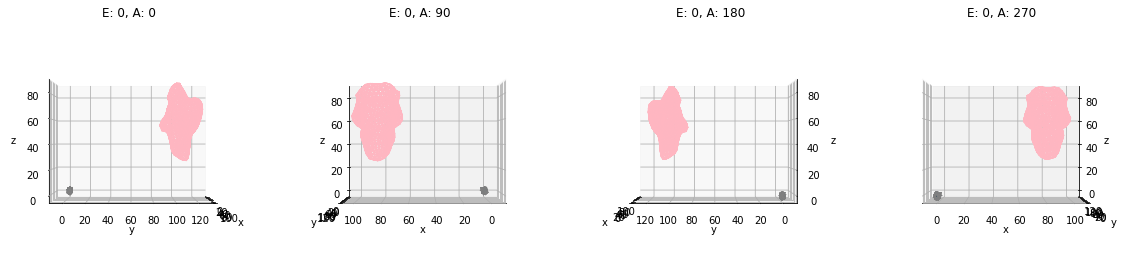

{'eid': 5272090, 'Sex': 0, 'Age': 52, 'Brain Stem Volume': 24183}


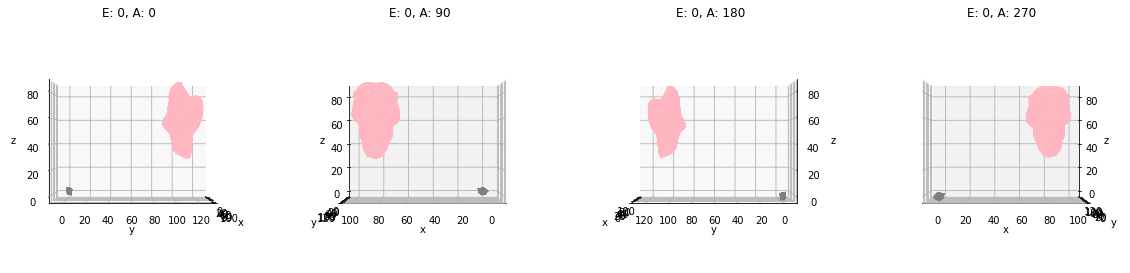

{'eid': 5178280, 'Sex': 1, 'Age': 61, 'Brain Stem Volume': 23390}


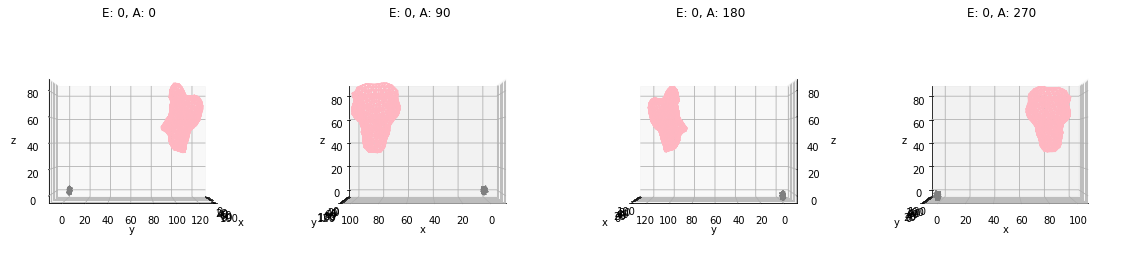

{'eid': 5548167, 'Sex': 1, 'Age': 63, 'Brain Stem Volume': 28637}


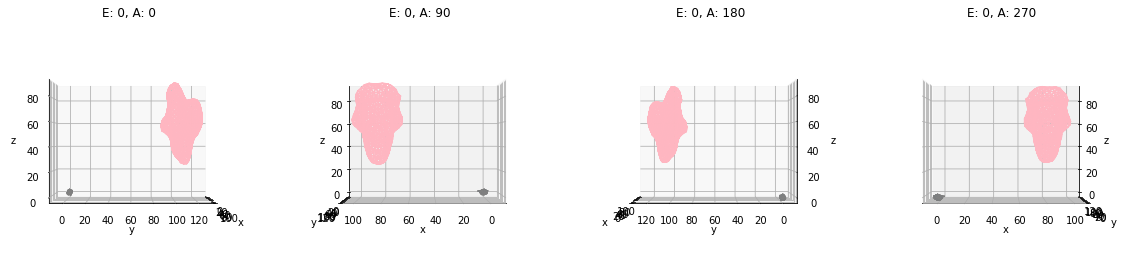

  0%|          | 0/262 [00:00<?, ?it/s]

-------------


100%|██████████| 15/15 [00:05<00:00,  2.62it/s]


5 7612361.480704216 7545647.117759354
{'eid': 5843672, 'Sex': 1, 'Age': 55, 'Brain Stem Volume': 26729}


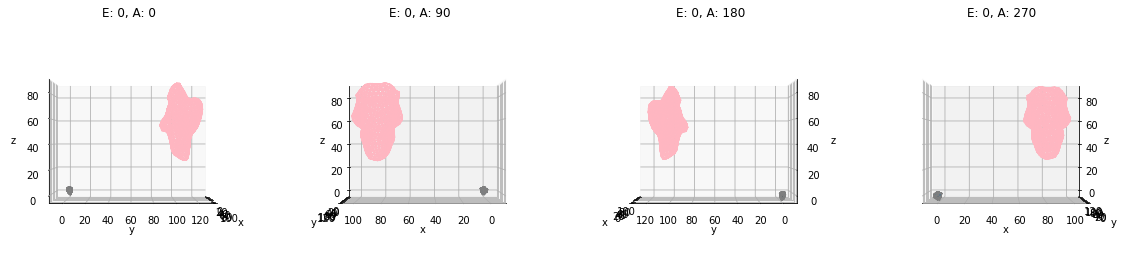

{'eid': 5272090, 'Sex': 0, 'Age': 52, 'Brain Stem Volume': 24183}


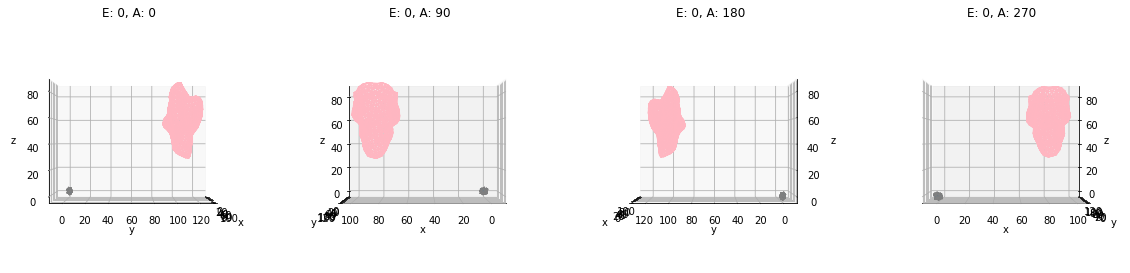

{'eid': 5178280, 'Sex': 1, 'Age': 61, 'Brain Stem Volume': 23390}


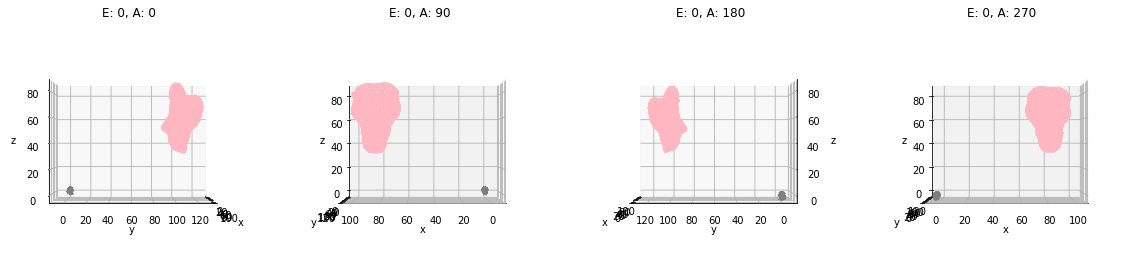

{'eid': 5548167, 'Sex': 1, 'Age': 63, 'Brain Stem Volume': 28637}


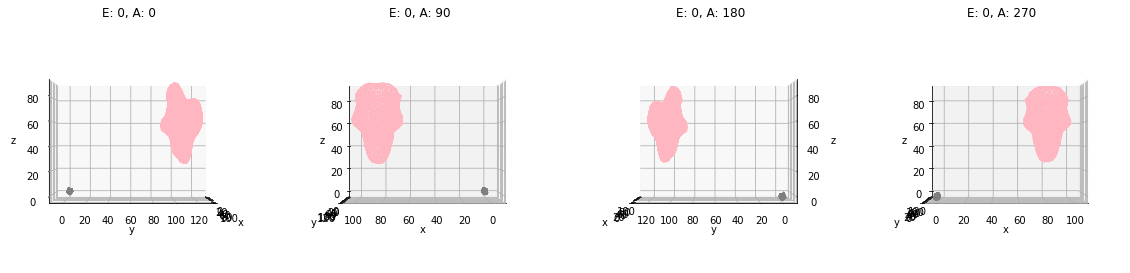

  0%|          | 0/262 [00:00<?, ?it/s]

-------------


100%|██████████| 15/15 [00:05<00:00,  2.70it/s]


6 7609475.0837644255 7612030.822362876
{'eid': 5843672, 'Sex': 1, 'Age': 55, 'Brain Stem Volume': 26729}


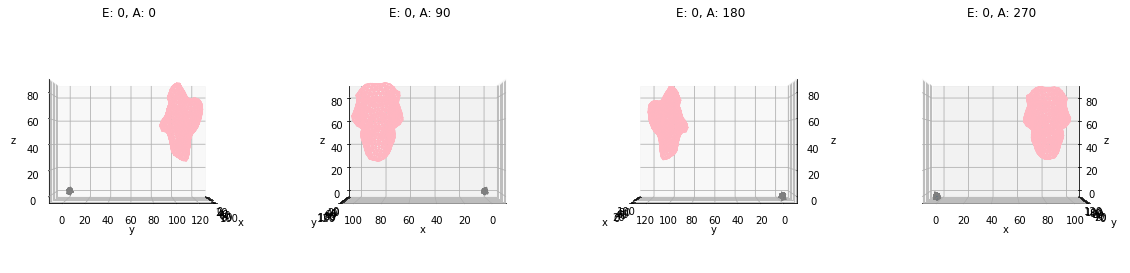

{'eid': 5272090, 'Sex': 0, 'Age': 52, 'Brain Stem Volume': 24183}


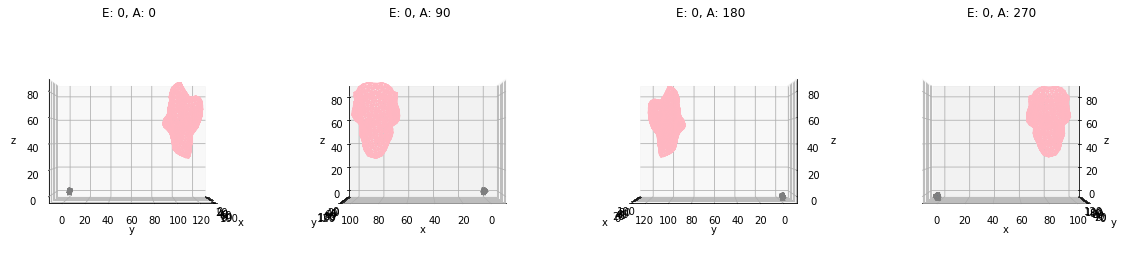

{'eid': 5178280, 'Sex': 1, 'Age': 61, 'Brain Stem Volume': 23390}


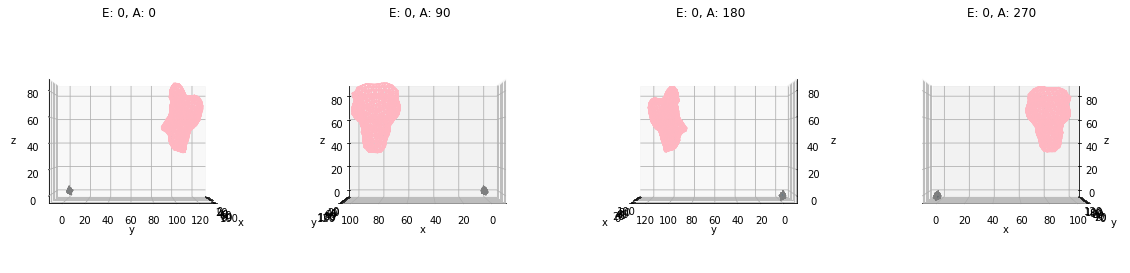

{'eid': 5548167, 'Sex': 1, 'Age': 63, 'Brain Stem Volume': 28637}


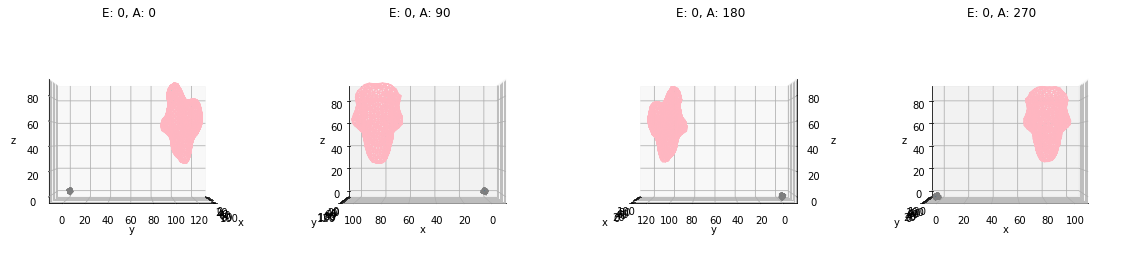

  0%|          | 0/262 [00:00<?, ?it/s]

-------------


100%|██████████| 15/15 [00:05<00:00,  2.92it/s]


7 7598341.674853027 7599785.8730617305
{'eid': 5843672, 'Sex': 1, 'Age': 55, 'Brain Stem Volume': 26729}


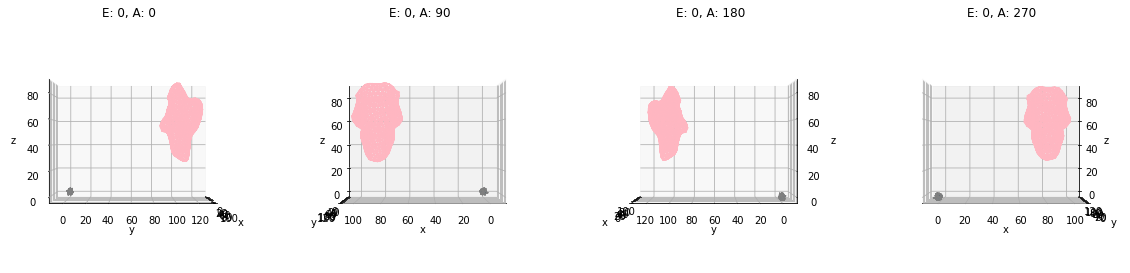

{'eid': 5272090, 'Sex': 0, 'Age': 52, 'Brain Stem Volume': 24183}


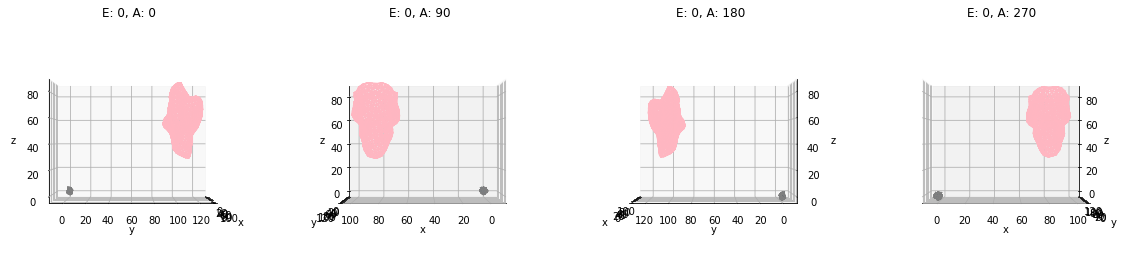

{'eid': 5178280, 'Sex': 1, 'Age': 61, 'Brain Stem Volume': 23390}


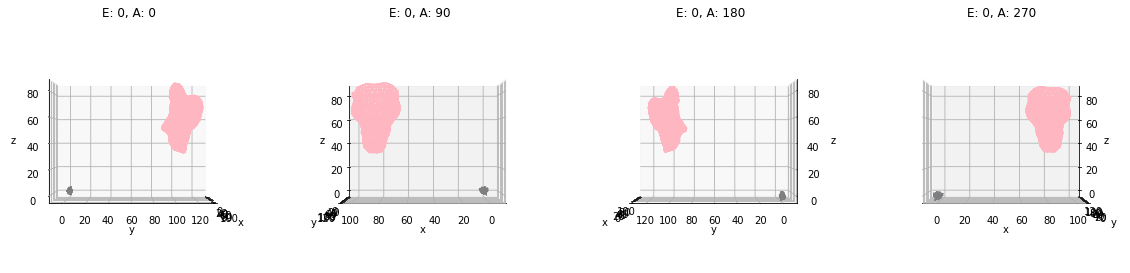

{'eid': 5548167, 'Sex': 1, 'Age': 63, 'Brain Stem Volume': 28637}


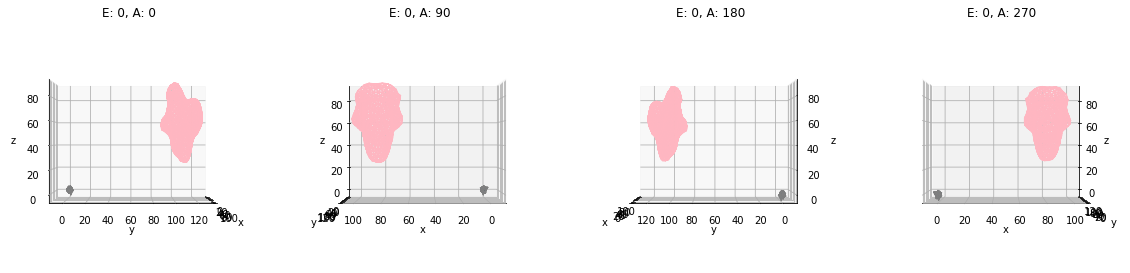

  0%|          | 0/262 [00:00<?, ?it/s]

-------------


100%|██████████| 15/15 [00:05<00:00,  2.93it/s]


8 7606299.744285689 7649858.658627712
{'eid': 5843672, 'Sex': 1, 'Age': 55, 'Brain Stem Volume': 26729}


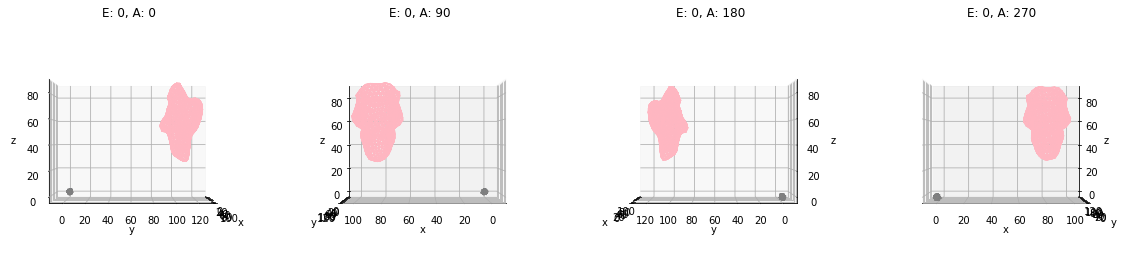

{'eid': 5272090, 'Sex': 0, 'Age': 52, 'Brain Stem Volume': 24183}


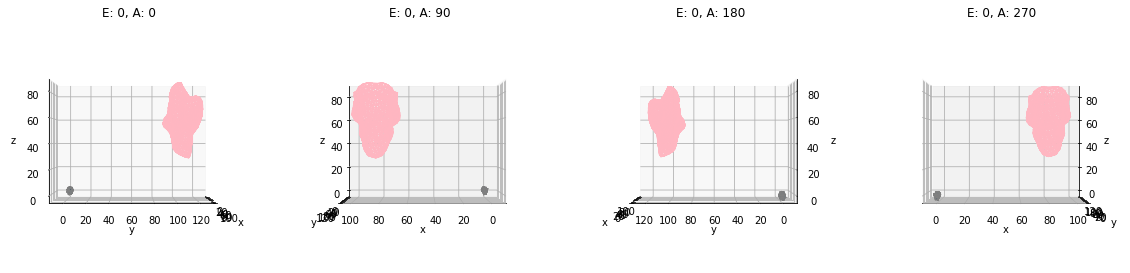

{'eid': 5178280, 'Sex': 1, 'Age': 61, 'Brain Stem Volume': 23390}


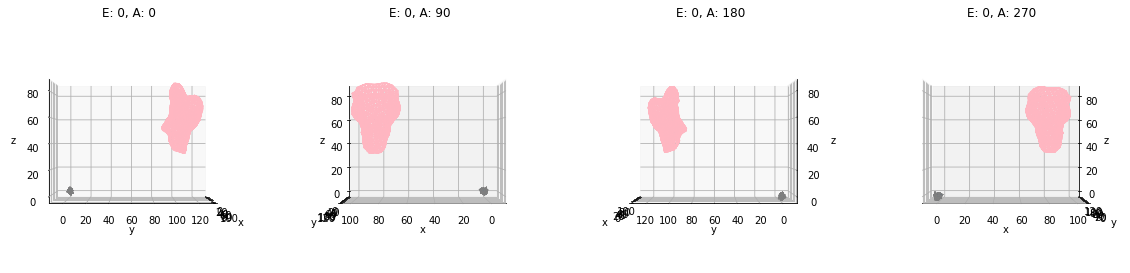

{'eid': 5548167, 'Sex': 1, 'Age': 63, 'Brain Stem Volume': 28637}


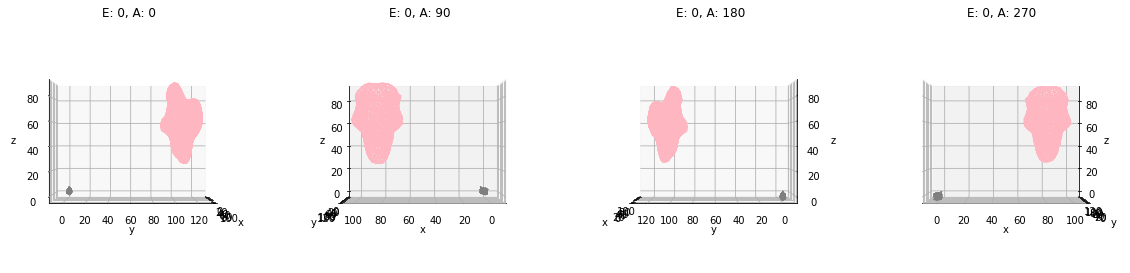

  0%|          | 0/262 [00:00<?, ?it/s]

-------------


100%|██████████| 15/15 [00:04<00:00,  3.14it/s]


9 7593545.50608028 7610608.736828145
{'eid': 5843672, 'Sex': 1, 'Age': 55, 'Brain Stem Volume': 26729}


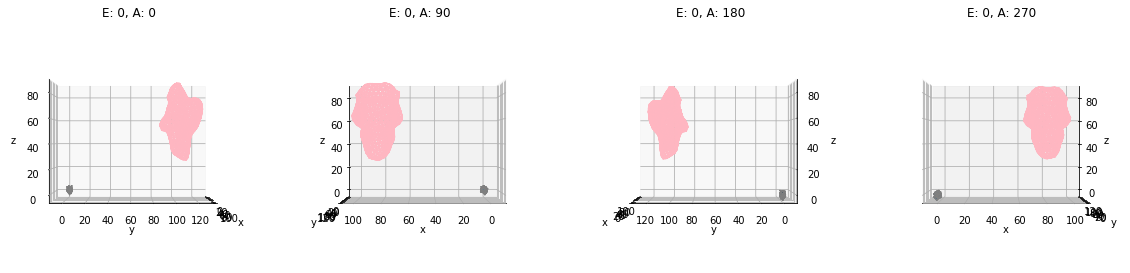

{'eid': 5272090, 'Sex': 0, 'Age': 52, 'Brain Stem Volume': 24183}


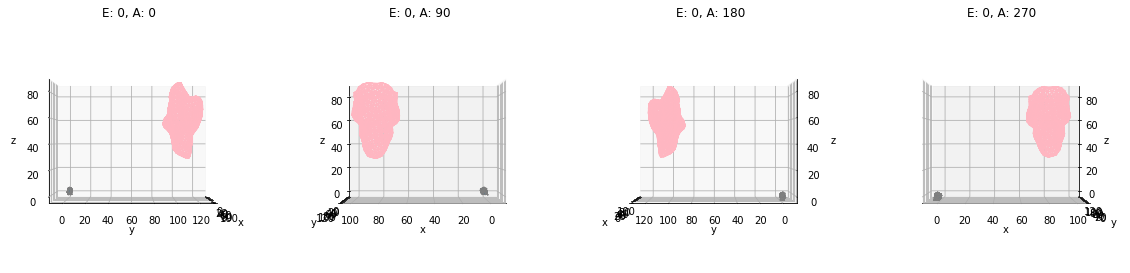

{'eid': 5178280, 'Sex': 1, 'Age': 61, 'Brain Stem Volume': 23390}


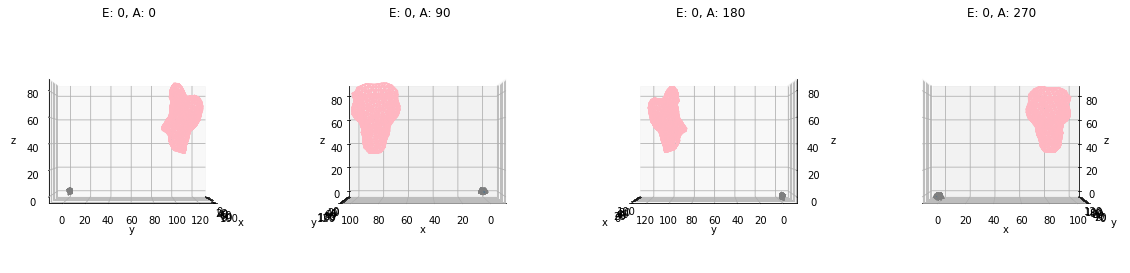

{'eid': 5548167, 'Sex': 1, 'Age': 63, 'Brain Stem Volume': 28637}


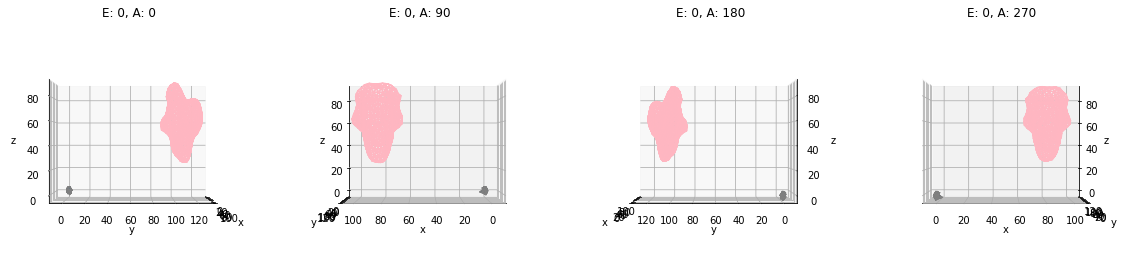

-------------


In [55]:
for i in range(10):
    train_loss = train_eval_svi(svi, train_dataloader, device)
    test_loss = train_eval_svi(svi, val_dataloader, device, train=False)
    print(i, train_loss, test_loss)
    
    # Point from validation dataset
    for i in range(3, idxs.shape[0]):
        print(dict(val_batch_df.iloc[i]))
        val_point = val_batch.x[idxs[i]].unsqueeze(0)
        pred = model.generate(val_point.to(device), device)
        pred = pred.cpu().detach().numpy().squeeze(0)
        plot_wireframe_and_meshes(pred, val_point.squeeze(0), template.face.T, elevations=[0], azimuths=4)
        
    print('-------------')